# CANDIDATES

The candidates file is a csv file that contains nodule candidate per line. Each line holds the scan name, the x, y, and z position of each candidate in world coordinates, and the corresponding class. The list of candidates is provided for participants who are following the ‘false positive reduction’ track. Tutorial on how to view lesions given the location of candidates will be available on the Forum page.

The candidate locations are computed using three existing candidate detection algorithms [1-3]. As lesions can be detected by multiple candidates, those that are located <= 5 mm are merged. Using this method, 1120 out of 1186 nodules are detected with 551,065 false positives. For convenience, the corresponding class label (0 for non-nodule and 1 for nodule) for each candidate is provided in the list. It has to be noted that there can be multiple candidates per nodule.

In [1]:
import numpy as np
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import fnmatch
import os
import SimpleITK as sitk
import time
from matplotlib.patches import Rectangle
pd.options.display.max_colwidth = 100

In [2]:
def findFullPaths(candidates):
    #candidates["seriesuidFullPaths"] = "toFind" # New column with new paths to find
    candidates = pd.read_csv("/home/msmith/luna16/CSVFILES/candidates.csv")
    include = ["subset" + str(i) for i in xrange(10)]
    directories = []
    for roots, dirs, files in os.walk('/home/msmith/luna16/',topdown=True):
            dirs[:] = [d for d in dirs if d in include]
            for d in dirs:
                directories.append(os.path.abspath(d))  
    fullPaths = []
    for directory in directories:
        for _,_,files in os.walk(directory):
            for x in files:
                fullPaths.append(os.path.abspath(os.path.join(directory,x)))

    rawPaths = [path for path in fullPaths if ".raw" in path]
    fullPath = lambda seriesuid: [s for s in rawPaths if seriesuid in s][0]
    candidates["seriesuidFullPath"] = candidates.seriesuid.apply(fullPath)
    #candidates.to_csv("/home/msmith/luna16/CSVFILES/candidatesFP.csv")

In [3]:
# Now to find voxel coords
def load_originSpacing(filename):
    itkimage = sitk.ReadImage(filename)
    numpyOrigin = np.array(list(reversed(itkimage.GetOrigin())))
    numpySpacing = np.array(list(reversed(itkimage.GetSpacing())))
    return numpyOrigin, numpySpacing

def worldToVoxelCoord(worldCoord, origin, spacing):
    stretchedVoxelCoord = np.absolute(worldCoord - origin)
    voxelCoord = stretchedVoxelCoord / spacing
    return voxelCoord

def getNVCmhd(row): # Much faster
    mhdPath = row["seriesuidFullPath"].replace(".raw",".mhd")
    with open(mhdPath,"r") as f:
        metaData = f.read()
        metaDataSplit = metaData.split("\n")
        imgOrigin = np.array(metaDataSplit[6].split(" ")[-3:]).astype(float)[::-1]
        imgSpacing = np.array(metaDataSplit[9].split(" ")[-3:]).astype(float)[::-1]

    noduleCoords = row['coordX'],row['coordY'],row['coordZ']
    noduleCoords = noduleCoords[::-1]
    nvc = worldToVoxelCoord(noduleCoords,imgOrigin,imgSpacing)
    nvc = np.array(nvc.astype(int))
    return np.array([nvc, imgSpacing])

def getSpacing(row):
    mhdPath = row["seriesuidFullPath"].replace(".raw",".mhd")
    _, imgSpacing = load_originSpacing(mhdPath)
    return imgSpacing


In [4]:
# Add voxel coords and spacing to original data set
def addVoxSpacing():
    candidates = pd.read_csv("/home/msmith/luna16/CSVFILES/candidatesFP.csv")
    candidates.rename(columns={'class':'Class'}, inplace=True)
    data = candidates
    start = time.clock()
    nObs = data.shape[0]
    xyz = data.apply(lambda row: pd.Series( dict(zip(["z","y","x","spacingZ","spacingY","spacingX"],getNVCmhd(row).flatten()))), axis=1)
    data = data.merge(xyz,left_index=True,right_index=True)
    end = time.clock()
    print("Time taken =", end-start)
    data.to_csv("/home/msmith/luna16/CSVFILES/candidatesFPNVC.csv")
    #data

In [4]:
candidates = pd.read_csv("/home/msmith/luna16/CSVFILES/candidatesFPNVC.csv")
candidatesSub = candidates[["seriesuidFullPath","Class","spacingX","spacingY","spacingZ","x","y","z"]]
#candidatesSub.to_csv("/home/msmith/luna16/CSVFILES/candidatesCleaned.csv",index=0)

In [9]:
data = candidatesSub.iloc[11105]
data[0]

'/home/msmith/luna16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949.raw'

## Display Image

('obs =', seriesuidFullPath    /home/msmith/luna16/subset7/1.3.6.1.4.1.14519.5.2.1.6279.6001.106379658920626694402549886949.raw
Class                                                                                                               1
spacingX                                                                                                      0.78125
spacingY                                                                                                      0.78125
spacingZ                                                                                                         1.25
x                                                                                                                 165
y                                                                                                                 343
z                                                                                                                  89
Name: 11105, dtype: object)
Image shape ==>
(2

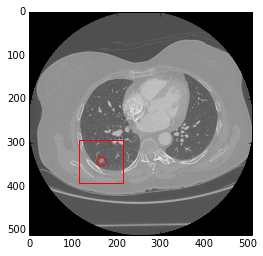

87


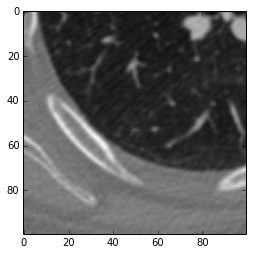

88


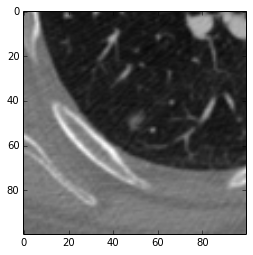

Nodule located here
89


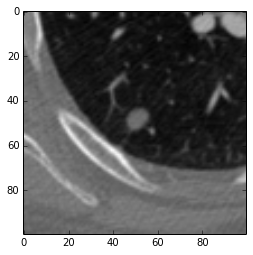

90


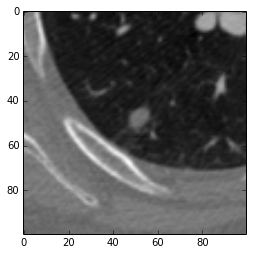

In [11]:
#Get a range in which to subset the data
data = candidatesSub
#data = candidatesSub.loc[(candidates.Class==1)] # Looking at confirmed nodules
#keep = np.random.randint(0,data.shape[0],10)
keep = 11105
data = data.iloc[keep]
#obs = data.iloc[0]
obs = data
nvc = np.array([obs.z,obs.y,obs.x]).astype(int)

mhdPath = obs.seriesuidFullPath.replace(".raw",".mhd")
itkimage = sitk.ReadImage(mhdPath)
img = sitk.GetArrayFromImage(itkimage)

margin = 50
nvcMinus,nvcPlus = (nvc - margin).astype(int), (nvc + margin).astype(int)
def printNoduleInfo():
    print("obs =", obs)
    print("Image shape ==>" + "\n" + str(img.shape))
    print("Nodule coordinates @"+"\n" + str(nvc))
    print("NVC margins ==>" + "\n" + str(nvcMinus) + "\n" + str(nvcPlus))
printNoduleInfo()

from matplotlib.patches import Rectangle
rectangle = plt.Rectangle((nvcMinus[2], nvcMinus[1]),margin*2 ,margin*2, facecolor = 'none', ec='r')
circle = plt.Circle((nvc[2],nvc[1]),10, facecolor = 'none', ec='r')
plt.gca().add_patch(rectangle)
plt.gca().add_patch(circle)
plt.imshow(img[nvc[0]],cmap=cm.gray)
plt.show()

for i in xrange(nvc[0]-2,nvc[0]+2,1):
    if i == nvc[0]:
        print("Nodule located here")
    print(i)
    plt.imshow(img[i,nvcMinus[1]:nvcPlus[1],nvcMinus[2]:nvcPlus[2]],cmap=cm.gray)
    plt.show()